Score: 0.13444

# Data Preprocessing

In [2]:
import pandas as pd
import numpy as np

In [3]:
training_data = pd.DataFrame.from_csv('train.csv')
test_data = pd.DataFrame.from_csv('test.csv')

df = pd.concat([training_data, test_data])
training_starting_idx = 0
training_ending_idx = len(training_data)

target = 'SalePrice'
features = [feature for feature in df.columns if feature != target]

Handling missing values

In [4]:
missing_values_stats = df.isnull().sum()

In [5]:
missing_values_stats[missing_values_stats!=0]

Alley           2721
BsmtCond          82
BsmtExposure      82
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFinType1      79
BsmtFinType2      80
BsmtFullBath       2
BsmtHalfBath       2
BsmtQual          81
BsmtUnfSF          1
Electrical         1
Exterior1st        1
Exterior2nd        1
Fence           2348
FireplaceQu     1420
Functional         2
GarageArea         1
GarageCars         1
GarageCond       159
GarageFinish     159
GarageQual       159
GarageType       157
GarageYrBlt      159
KitchenQual        1
LotFrontage      486
MSZoning           4
MasVnrArea        23
MasVnrType        24
MiscFeature     2814
PoolQC          2909
SalePrice       1459
SaleType           1
TotalBsmtSF        1
Utilities          2
dtype: int64

dropping features which have too many missing values

In [6]:
drop_columns = [col for col in features if df[col].isnull().sum() > 1000]
df.drop(drop_columns, 1, inplace=True)

In [7]:
features = list(filter(lambda x: x not in drop_columns, features))

In [8]:
numerical_features = []
categorical_features = []
for var in features:
    if 1. * df[training_starting_idx: training_ending_idx][var].nunique() / df[training_starting_idx: training_ending_idx][var].count() < 0.05:
        categorical_features.append(var)
        df[var] = df[var].astype('category')
    else:
        numerical_features.append(var)
        df[var] = df[var].astype(float)

In [9]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df[training_starting_idx: training_ending_idx][numerical_features])
df[numerical_features] = imr.transform(df[numerical_features].values)

In [10]:
for var in categorical_features:
    df[var] = df[var].fillna(df[training_starting_idx: training_ending_idx][var].value_counts().idxmax())

In [11]:
assert df[features].isnull().sum().sum() == 0

Handling categorical variables

In [12]:
df = pd.get_dummies(df)

Handling skewness

In [13]:
from scipy.stats import skew

In [14]:
skewed_feats = df[numerical_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

In [15]:
df[skewed_feats] = np.log1p(df[skewed_feats])

Scaling numerical features

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
stdsc = StandardScaler()

In [18]:
stdsc.fit(df[training_starting_idx: training_ending_idx][numerical_features])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
df[numerical_features] = stdsc.transform(df[numerical_features])

# Fit a Lasso model

In [20]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [21]:
training_features = list(filter(lambda x: x != 'SalePrice', df.columns))

In [22]:
train_X = df[training_starting_idx: training_ending_idx][training_features]
train_Y = np.log1p(df[training_starting_idx: training_ending_idx]['SalePrice'])

In [23]:
model_lasso = LassoCV(alphas = [100, 10, 1, 0.1, 0.001, 0.0005], max_iter=100000).fit(train_X, train_Y)

# Model evaluation

taking a look at the selected features

In [24]:
coef = pd.Series(model_lasso.coef_, index = training_features)

In [25]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 150 variables and eliminated the other 385 variables


In [26]:
imp_coef = pd.concat([coef.sort_values().head(15),
                      coef.sort_values().tail(15)])

In [27]:
import matplotlib.pyplot as plt
import matplotlib

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

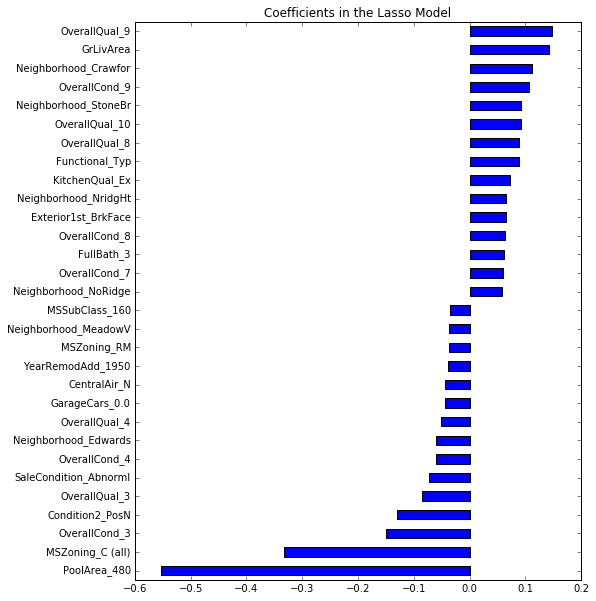

In [28]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [29]:
model_lasso.score(train_X, train_Y)

0.93196774266827853

# Prediction

In [30]:
test_X = df[training_ending_idx:][training_features]

In [31]:
predictions = np.exp(model_lasso.predict(test_X))-1

In [32]:
predictions = pd.Series(predictions, index=range(training_ending_idx+1, training_ending_idx+1+len(test_X)))

In [33]:
predictions.to_csv('better_lasso.csv')

# Adding XGBOOST

windows installation instruction
https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_For_Anaconda_on_Windows?lang=en

In [34]:
import xgboost as xgb

In [35]:
dtrain = xgb.DMatrix(train_X, label=train_Y)
dtest = xgb.DMatrix(test_X)

params = {'max_depth': 2, 'eta': 0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=500)

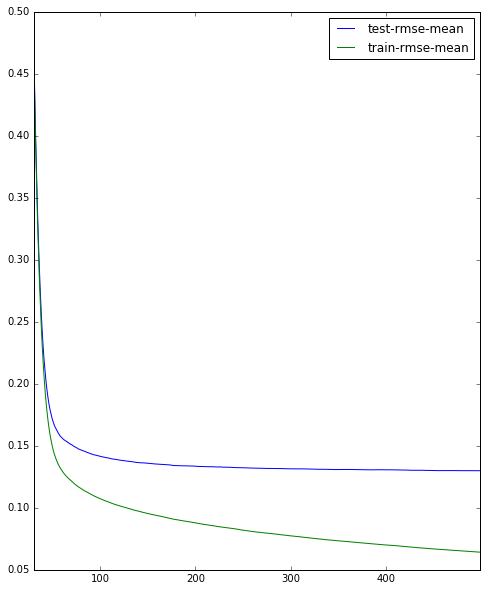

In [37]:
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot()

In [38]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [39]:
xgb_preds = np.expm1(model_xgb.predict(test_X))

In [42]:
xgb_preds = pd.Series(xgb_preds, index=range(training_ending_idx+1, training_ending_idx+1+len(test_X)))

In [44]:
xgb_preds.to_csv('xgb.csv')

# Lasso + XGB

In [47]:
lasso_xgb = (predictions + xgb_preds)/2

In [48]:
xgb_preds.to_csv('lasso_xgb.csv')

In [52]:
xgb_preds = xgb_preds.reset_index()

In [53]:
xgb_preds.columns = ['Id', 'SalePrice']

In [55]:
xgb_preds.to_csv('lasso_xgb.csv', index=False)